In [202]:
from sklearn.base import BaseEstimator
from sklearn.utils.validation import check_X_y, check_is_fitted
import pandas as pd

In [203]:
class CarClassifier(BaseEstimator):
    def __init__(self,minsup=0.3,minconf=0.7):
        self.minsup = minsup
        self.minconf = minconf

    def getConf(self, name):
        if(type(self.minconf)==float):
            return self.minconf
        else:
            return self.minconf[name]

    def fit(self,X,y):
        # Check that X.shape[0]==y.shape[0] 
        # X, y = check_X_y(X, y)
        self.X_ = X
        self.y_ = y

        rules = self.build_()
        self.cover_(rules)

        return True

    def predict_(self,X):
        # Check that fit has been called
        check_is_fitted(self)

        for i in self.rules.index:
            ans = self.predict_compare(self.rules.loc[i],X)
            if(ans==-1):
                continue
            else:
                return ans

        return self.maj

    def predict(self,X):
        y_ = []
        for i in X.index:
            y_ += [self.predict_(X.loc[i])]
    
        return pd.Series(y_, index=X.index)


    def predict_compare(self,df1,df2):
        without = list(df1.index)
        without.remove(self.y_.name)
        without.remove('sup')
        without.remove('rsup')
        without.remove('acc')
        without.remove('err')
        without.remove('maj')
        for i in without:
            if(not pd.isnull(df1[i]) and df1[i]!=df2[i]):
                return -1
        
        return df1[self.y_.name]


    def build_(self) -> dict:
        rules = dict()
        temp_rules = self.initial_build_()
        self.transfer_dict(rules,temp_rules)

        while(self.isempty(temp_rules)):
            candidates = self.gen_new_cand(temp_rules)
            temp_rules = self.prune_rules(candidates)
            self.transfer_dict(rules,temp_rules)

        return rules
    
    def isempty(self,rules:dict) -> int:
        for i in rules:
            if(rules[i]!=[]):
                return 1
        return 0

    def initial_build_(self) -> dict:
        temp_rules = dict()
        for i in self.X_:
            vals = pd.concat([self.X_[i],self.y_],axis=1,names=["pred","resp"]).value_counts()
            val = self.X_[i].value_counts()
            for j in vals.index:
                if(val[j[0]]>=self.minsup and vals[j]/val[j[0]]>=self.getConf(j[1])):
                    if(j[1] not in temp_rules):
                        temp_rules[j[1]] = list()
                        
                    temp_rules[j[1]].append({
                        "pred":{i:j[0]},
                        "sup":val[j[0]],
                        "rsup":vals[j]
                    })
                    
        return temp_rules

    def gen_new_cand(self,temp_rules) -> dict:
        cands = dict()
        for i in temp_rules:
            cands[i] = list()
            l = self.comb_cand(temp_rules[i])
            self.add_support(l,i)
            cands[i] = cands[i] + l
        return cands


    def transfer_dict(self,dict1,dict2) -> None:
        for i in dict2:
            if(i not in dict1):
                dict1[i] = list()
            dict1[i].append(dict2[i])

    def combine_dict(self,dict1,dict2) -> dict:
        temp = dict()
        for i in dict1:
            temp[i] = dict1[i]
        for i in dict2:
            temp[i] = dict2[i]
        return temp


    def comb_cand(self,cand:list) -> list:
        cands = list()
        for i in range(len(cand)):
            for j in range(i+1,len(cand)):
                comp1 = sorted(list(cand[i]["pred"].keys()))[:-1]
                comp2 = sorted(list(cand[j]["pred"].keys()))[:-1]
                if(comp1==comp2):
                    cands.append({
                        "pred":self.combine_dict(cand[i]["pred"],cand[j]["pred"])
                    })
        return cands

    def add_support(self, l:list, y):
        for i in l:
            i["sup"], i["rsup"] = self.getsup(i,y)

    def getsup(self, diction:dict,y) -> int:
        filterList = list(diction["pred"].items())
        _Xy = pd.concat([self.X_,self.y_],axis=1)
        for t in filterList:
            _Xy = _Xy[_Xy[t[0]]==t[1]]
        
        ans1 = len(_Xy)
        ans2 = len((_Xy[_Xy[self.y_.name]==y]))

        return ans1, ans2

    def prune_rules(self,candidates):
        return candidates

    def cover_(self, rules: dict) -> None:
        df_rules = self.pre_cover(rules)
        _Xy = pd.concat([self.X_,self.y_],axis=1)
        final_rules = pd.DataFrame(columns=df_rules.columns)
        final_rules["err"] = 0
        final_rules["maj"] = 0
        
        for i in df_rules.index:
            if(len(_Xy)==0):
                break
            sup = 0
            err = 0
            pre_index =  _Xy.index
            for j in pre_index:
                sup_plus,err_plus = self.compare(df_rules.loc[i],_Xy.loc[j])
                if(sup_plus):
                    _Xy.drop(j,axis=0,inplace=True)
                    sup = sup + sup_plus
                    err = err + err_plus 
                    
            if(len(_Xy)!=0):
                vals = _Xy[self.y_.name].value_counts()
                majority = vals[vals.index[0]]
                err_extra = len(_Xy) - majority
                err = err + err_extra
                
            if(sup!=0):
                new_df = df_rules[df_rules.index==i]
                # new_df["err"] = err
                # new_df["maj"] = vals.index[0]
                new_df = new_df.assign(err = lambda x: (err))
                new_df = new_df.assign(maj = lambda x: (vals.index[0]))
                final_rules = pd.concat([final_rules,new_df],axis=0)
        
        self.rules = pd.DataFrame(columns=df_rules.columns)
        self.rules["err"] = 0
        self.rules["maj"] = 0

        min_err = min(final_rules["err"])
        for i in final_rules.index:
            if(final_rules.at[i,"err"]==min_err):
                self.maj = (final_rules[final_rules.index==i])["maj"][i]
                break
            self.rules = pd.concat([self.rules,final_rules[final_rules.index==i]],axis=0)

            

    def compare(self,df1,df2)->int:
        without_y = list(df1.index)
        without_y.remove(self.y_.name)
        without_y.remove('sup')
        without_y.remove('rsup')
        without_y.remove('acc')
        for i in without_y:
            if(not pd.isnull(df1[i]) and df1[i]!=df2[i]):
                return 0,0
        
        if(df1[self.y_.name]==df2[self.y_.name]):
            return 1,0  # rule with no errors
        else:
            return 1,1  # rule with error


    def pre_cover(self,rules:dict) -> pd.DataFrame:
        arr = []
        for i in rules:
            for j in rules[i]:
                for k in j:
                    k[self.y_.name] = i
                    arr.append(k)
        dat = pd.json_normalize(arr)
        dat["acc"] = dat["rsup"]/dat["sup"]
        dat.sort_values(by=["acc","sup"],ascending=False, inplace=True)
        
        cols = list(dat.columns)
        for i in range(len(cols)):
            cols[i] = cols[i].replace("pred.","")
        dat.columns = cols
        
        return dat

In [204]:
from sklearn.datasets import load_iris
data = load_iris(as_frame=True)
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    data.data, data.target, random_state=0)

In [205]:
from jenkspy import JenksNaturalBreaks
import numpy as np
def govf(jnb, arr):
    sdam = np.sum((arr - arr.mean()) ** 2)
    sdcm = sum([np.sum((g - g.mean()) ** 2) for g in jnb.groups_])
    return (sdam - sdcm) / sdam
def binit(ser: pd.Series, MAXCAT: int) -> (pd.Series, object):
    opt = MAXCAT
    for k in range(2,MAXCAT):
        jnb = JenksNaturalBreaks(k)
        arr = np.array(ser)
        jnb.fit(arr)
        thresh = govf(jnb,arr)
        if(thresh>0.8):
            opt = k
            break
    jnb = JenksNaturalBreaks(opt)
    arr = np.array(ser)
    jnb.fit(arr)
    lab = jnb.labels_
    breaks = ["-inf"]+ [str(i) for i in jnb.inner_breaks_]  + ["+inf"]
    ans = []
    for i in lab:
        ans = ans + [breaks[i] + "< "+ ser.name +" <"+ breaks[i+1]]
    return (pd.Series(ans, index=ser.index),jnb)
def process(data, name) -> (pd.Series, object):
    var = data[name]
    var_notna = var[var.notna()]
    var_, jnb_ = binit(var_notna,10)
    var_cleaned = []
    counter = 0
    for i in range(len(var)):
        if(pd.notna(list(var.index)[i])):
            var_cleaned += [var_[list(var_.index)[i-counter]]]
        else:
            var_cleaned += [None]
            counter = counter+1
    return (pd.Series(var_cleaned,name=name, index=data.index), jnb_)

def binit_predict(ser: pd.Series, jnb) -> pd.Series:
    lab = [jnb.predict(i) for i in ser]
    breaks = ["-inf"]+ [str(i) for i in jnb.inner_breaks_]  + ["+inf"]
    ans = []
    for i in lab:
        ans = ans + [breaks[i] + "< "+ ser.name +" <"+ breaks[i+1]]
    return pd.Series(ans, index=ser.index)

def transform(data, name, jnb):
    var = data[name]
    var_notna = var[var.notna()]
    var_ = binit_predict(var_notna,jnb)
    var_cleaned = []
    counter = 0
    for i in range(len(var)):
        if(pd.notna(list(var.index)[i])):
            var_cleaned += [var_[list(var_.index)[i-counter]]]
        else:
            var_cleaned += [None]
            counter = counter+1
    return pd.Series(var_cleaned,name=name, index=data.index)

In [206]:
Col1, jnb1 = process(X_train,"sepal length (cm)")
Col2, jnb2 = process(X_train,"sepal width (cm)")
Col3, jnb3 = process(X_train,"petal length (cm)")
Col4, jnb4 = process(X_train,"petal width (cm)")

In [207]:
c = CarClassifier(0.8,0.6)
r = c.fit(pd.concat([Col1,Col2,Col3,Col4],axis=1),y_train)
c.rules

,sup,rsup,target,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),acc,err,maj
3,37,37,0,NaN,NaN,NaN,-inf< petal width (cm) <0.6,1.000000,34,2
2,38,37,0,NaN,NaN,-inf< petal length (cm) <3.0,NaN,0.973684,34,2
17,25,24,2,6.4< sepal length (cm) <+inf,NaN,NaN,1.6< petal width (cm) <+inf,0.960000,18,1
16,40,38,2,NaN,NaN,NaN,1.6< petal width (cm) <+inf,0.950000,4,1


In [208]:
Col1 = transform(X_val,"sepal length (cm)", jnb1)
Col2 = transform(X_val,"sepal width (cm)", jnb2)
Col3 = transform(X_val,"petal length (cm)", jnb3)
Col4 = transform(X_val,"petal width (cm)", jnb4)

In [209]:
y_ = []
X_val = pd.concat([Col1,Col2,Col3,Col4],axis=1)
for i in X_val.index:
    y_ += [c.predict_(X_val.loc[i])]

In [210]:
pd.Series([str(i) for i in y_]).value_counts()

1    17
0    13
2     8
dtype: int64

In [211]:
pd.Series([str(i) for i in y_val]).value_counts()

1    16
0    13
2     9
dtype: int64

In [212]:
from sklearn.inspection import permutation_importance

In [213]:
from sklearn.metrics import f1_score

In [214]:
r = permutation_importance(c, X_val, y_val,
                           n_repeats=30,
                           random_state=0,
                           scoring="f1_macro")

In [218]:
import seaborn as sb

<AxesSubplot:>

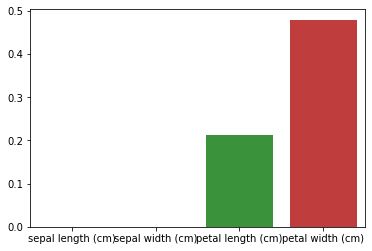

In [226]:
sb.barplot(y=r["importances_mean"],x= list(X_train.columns))

In [225]:
list(X_train.columns)

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']